<a href="https://colab.research.google.com/github/lucasdelimanogueira/LSTM-from-scratch/blob/main/LSTM_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and auxiliary functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from io import StringIO
from sklearn.model_selection import train_test_split

def split_sequence(sequence, n_steps, ts_forecast):
        """Prepare the data for training, separating it into x and y_expected
        Ex: LSTM with 3 cells
        
        Series 1,2,3,4,5,6,7...

        Turn it into 

          x,     y_expected
        [1,2,3], [4]
        [2,3,4], [5]
        [4,5,6], [7]...
        """
        
        X, y = list(), list()
        for i in sequence.index:
            # find the end of this pattern
            end_ix = i + n_steps - 1 
            # check if we are beyond the sequence
            if end_ix + ts_forecast > sequence.index[-1]:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence.loc[i:end_ix], sequence[end_ix + ts_forecast]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

# Dataset

In [ ]:
orig_url='https://drive.google.com/file/d/1wG_Usg-NCXKEBGFRbtI2PQndhyKibDeo/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
time_series = pd.read_csv(StringIO(url), header=None, squeeze=True)

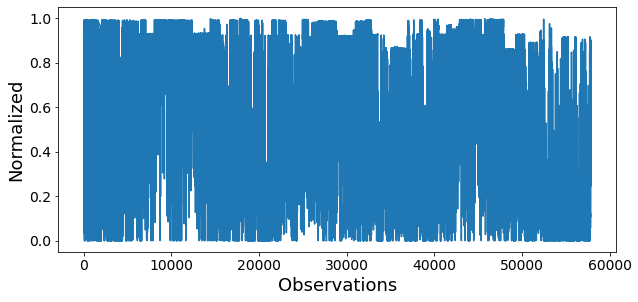

In [ ]:
plt.figure(figsize=(10, 4.5))

plt.plot(time_series)

plt.xlabel('Observations', fontsize=18)
plt.ylabel('Normalized', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Separating in train, test and validation 

In [ ]:
series_train_tmp, series_test = train_test_split(time_series, test_size=0.2, shuffle=False)
series_train, series_validation = train_test_split(series_train_tmp, test_size=0.2, shuffle=False)

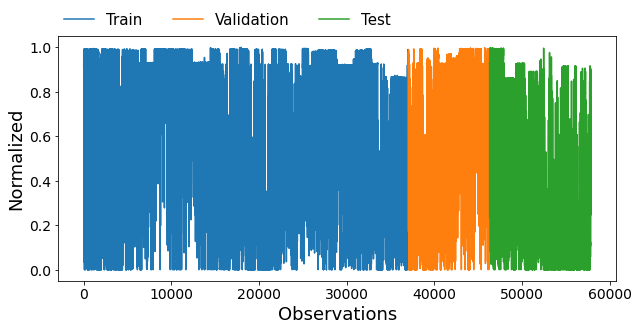

In [ ]:
plt.figure(figsize=(10, 4.5))

plt.plot(series_train, label = 'Train')
plt.plot(series_validation, label = 'Validation')
plt.plot(series_test, label = 'Test')

plt.xlabel('Observations', fontsize=18)
plt.ylabel('Normalized', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

# LSTM model

In [33]:
class LSTM:
    
    def __init__(self, x_dimension, y_dimension, number_hidden_neurons, number_of_cells, learning_rate):
        """Inicialização de matrizes e vetores para o modelo"""
        self.x_dimension = x_dimension # input dimension
        self.y_dimension = y_dimension # output dimension
        self.number_of_cells = number_of_cells # lstm cells amount
        self.learning_rate = learning_rate # learning rate
        self.number_hidden_neurons = number_hidden_neurons # hidden neurons amount
        
        self.f_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # forget states storage
        self.h_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # hidden states storage
        self.c_cand_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # cell candidates states storage
        self.c_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # cell states storage
        self.o_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # outputs storage
        self.i_list = [np.zeros((number_hidden_neurons,1)) for _ in range(number_of_cells)] # inputs storage 
        
        self.wf = np.random.random((number_hidden_neurons, x_dimension+number_hidden_neurons))/np.sqrt(x_dimension+self.number_hidden_neurons) # forget gate weights 
        self.wi = np.random.random((number_hidden_neurons, x_dimension+number_hidden_neurons))/np.sqrt(x_dimension+self.number_hidden_neurons) # input gate weights
        self.wc = np.random.random((number_hidden_neurons, x_dimension+number_hidden_neurons))/np.sqrt(x_dimension+self.number_hidden_neurons) # cell state gate weights
        self.wo = np.random.random((number_hidden_neurons, x_dimension+number_hidden_neurons))/np.sqrt(x_dimension+self.number_hidden_neurons) # output gate weights
                
        self.bf = np.random.random((number_hidden_neurons, 1)) # forget gate bias
        self.bi = np.random.random((number_hidden_neurons, 1)) # input gate bias
        self.bc = np.random.random((number_hidden_neurons, 1)) # cell state gate bias
        self.bo = np.random.random((number_hidden_neurons, 1)) # output gate bias
        
        self.w_final = np.random.random((y_dimension, number_hidden_neurons)) # final output weights
        self.b_final= np.random.random((y_dimension, 1)) # final output bias
    
    def forward(self, x):
        x = np.array(x)
        """Given an input x, return the output prediction y"""
        self.x = x
        for t in range(1, self.number_of_cells):
            f = self.sigmoid(self.wf @ np.vstack((self.h_list[t-1], self.x[t])) + self.bf) # f = sig(wf.[ht-1,xt] + bf)
            i = self.sigmoid(self.wi @ np.vstack((self.h_list[t-1], self.x[t])) + self.bi) # i = sig(wi.[ht-1,xt] + bi)
            c_cand = self.tanh(self.wc @ np.vstack((self.h_list[t-1], self.x[t])) + self.bc) # c = tanh(wc.[ht-1,xt] + bc)
            
            c = f*self.c_list[t-1] + i*c_cand # c = f*ct-1 + i*c
            o = self.sigmoid(self.wo @ np.vstack((self.h_list[t-1], self.x[t])) + self.bo) # o = sig(wo.[ht-1,xt] + bo)
            h = o*self.tanh(c)
            
            # storages the values to use on the next iteration
            self.f_list[t] = f
            self.h_list[t] = h
            self.c_list[t] = c
            self.c_cand_list[t] = c_cand
            self.o_list[t] = o
            self.i_list[t] = i
            
        # return final output
        y_pred = self.w_final @ self.h_list[-1] + self.b_final
        return y_pred
    
    
    def backpropagate(self,y_expected, y_pred):       
        """Given the expected and predicted outputs, calculate the delta values using backpropatation through time"""
        delta_h_list = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δh
        delta_o_list = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δo
        delta_c_list = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δc
        delta_f_list = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δf
        delta_i_list = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δi
        delta_c_cand = [np.zeros((self.number_hidden_neurons,1)) for _ in range(self.number_of_cells+1)] # storages δc_candidate
       
        # storages the deltas of weights and biases
        dw_final = np.zeros_like(self.w_final)
        db_final = np.zeros_like(self.b_final)      

        dwf = np.zeros_like(self.wf)
        dbf = np.zeros_like(self.bf)
            
        dwi = np.zeros_like(self.wi)
        dbi = np.zeros_like(self.bi)
            
        dwo = np.zeros_like(self.wo)
        dbo = np.zeros_like(self.bo)
        
        dwc = np.zeros_like(self.wc)
        dbc = np.zeros_like(self.bc)


        # calculates deltas
        delta_e = y_expected - y_pred

        dw_final = delta_e * self.h_list[-1].T
        db_final = delta_e 

        
        for t in reversed(range(self.number_of_cells)):

            delta_h_list[t] = self.w_final.T @ delta_e + delta_h_list[t+1]
            delta_o_list[t] = self.tanh(self.c_list[t])*delta_h_list[t] * self.prime_sigmoid(self.h_list[t])
            delta_c_list[t] = self.o_list[t]*delta_h_list[t]*self.prime_tanh(self.c_list[t]) + delta_c_list[t+1]
            delta_f_list[t] = self.c_list[t-1]*delta_c_list[t]*self.prime_sigmoid(self.f_list[t])
            delta_i_list[t] = self.c_cand_list[t]*delta_c_list[t]*self.prime_sigmoid(self.i_list[t])
            delta_c_cand[t] = self.i_list[t]*delta_c_list[t]*self.prime_tanh(self.c_cand_list[t])
            
            z = np.vstack((self.h_list[t-1], self.x[t]))
            
            # accumulates all deltas
            dwf += delta_f_list[t] @ z.T
            dbf += delta_f_list[t]
            
            dwi += delta_i_list[t] @ z.T
            dbi += delta_i_list[t]
            
            dwo += delta_o_list[t] @ z.T
            dbo += delta_o_list[t]
            
            dwc += delta_c_list[t] @ z.T
            dbc += delta_c_list[t]            

        return dw_final, db_final, dwf/self.number_of_cells, dbf/self.number_of_cells, dwi/self.number_of_cells, dbi/self.number_of_cells, dwo/self.number_of_cells, dbo/self.number_of_cells, dwc/self.number_of_cells, dbc/self.number_of_cells
        
        
            
    def fit(self, epochs, x, y_expected, x_validation=None, y_expected_validation=None):
        """Treina o modelo"""

        loss_training_lista = [] # training loss function list
        loss_validation_lista = [] # validation loss function list
        
        for _ in range(epochs):
            
            loss_training = 0
            loss_validation = 0
            for i in range(len(x)):
            
                # get predicted y
                y_pred = self.forward(x[i])

                # backpropagates the error
                dw_final, db_final, dwf, dbf, dwi, dbi, dwo, dbo, dwc, dbc = self.backpropagate(y_expected[i], y_pred)

                # updating of weights and biases
                self.w_final = self.w_final + self.learning_rate*dw_final
                self.b_final = self.b_final + self.learning_rate*db_final   

                self.wf = self.wf + self.learning_rate*dwf
                self.bf = self.bf + self.learning_rate*dbf

                self.wi = self.wi + self.learning_rate*dwi
                self.bi = self.bi + self.learning_rate*dbi

                self.wo = self.wo + self.learning_rate*dwo
                self.bo = self.bo + self.learning_rate*dbo

                self.wc = self.wc + self.learning_rate*dwc
                self.bc = self.bc + self.learning_rate*dbc

                loss_training += ((y_expected[i] - y_pred)**2)/2

            loss_training_lista.append(loss_training)

            # check overfitting
            if x_validation is not None and y_expected_validation is not None:
              y_pred_validation = self.predict(x_validation)
              y_pred_validation = y_pred_validation.reshape((y_pred_validation.shape[0], 1))
              y_expected_validation = y_expected_validation.reshape((y_expected_validation.shape[0], 1))

              loss_validation = np.sum( (y_expected_validation - y_pred_validation)**2 , axis =0)/2
              loss_validation_lista.append(loss_validation)

        if x_validation is not None and y_expected_validation is not None:
          
          return np.concatenate(loss_training_lista), np.concatenate(loss_validation_lista)
    
    def predict(self, x):
                
        y_pred = []

        for i in range(len(x)):
            y_pred.append( self.forward(x[i]) )
            
        return np.concatenate(y_pred)
        
    def sigmoid(self, z):
        """Sigmoid function"""
        return 1/(1+np.exp(-z))

    def prime_sigmoid(self, z):
        """Sigmod prime function"""
        return self.sigmoid(z) * (1 - self.sigmoid(z))  

    def tanh(self, z):
        """Tanh function"""
        return np.tanh(z)

    def prime_tanh(self, z):
        """Tanh prime function"""
        return 1-(z**2)

# Train and Test
The hyperparameters tuning using the validation data was omitted for reasons of facilitating the understanding of the algorithm

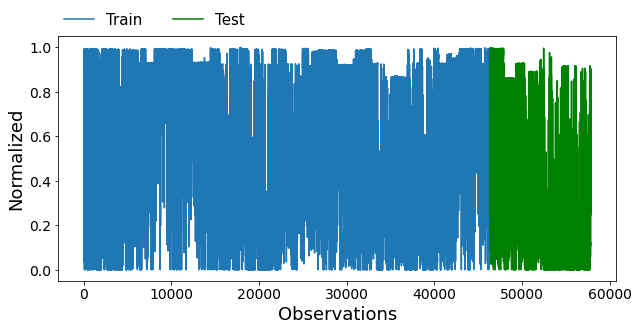

In [11]:
plt.figure(figsize=(10, 4.5))

plt.plot(series_train_tmp, label = 'Train')
plt.plot(series_test, label = 'Test', color='green')

plt.xlabel('Observations', fontsize=18)
plt.ylabel('Normalized', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

In [12]:
n_inputs = 2
forecast_horizon = 1

X_train, y_train = split_sequence(series_train_tmp, n_inputs, forecast_horizon)
X_test, y_test = split_sequence(series_test, n_inputs, forecast_horizon)

In [34]:
lstm = LSTM(x_dimension=1, y_dimension=1, number_hidden_neurons=3, number_of_cells=n_inputs, learning_rate=0.001)
lstm.fit(epochs=10, x=X_train, y_expected=y_train)

In [35]:
y_pred_lstm_horizon1 = lstm.predict(X_test)

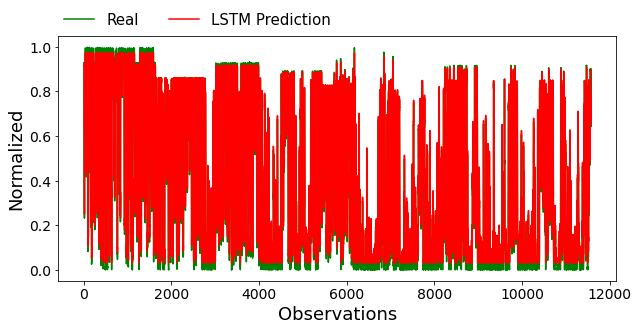

In [36]:
plt.figure(figsize=(10, 4.5))

plt.plot(y_test, label='Real', color='green')
plt.plot(y_pred_lstm_horizon1, label='LSTM Prediction', color='red')

plt.xlabel('Observations', fontsize=18)
plt.ylabel('Normalized', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()

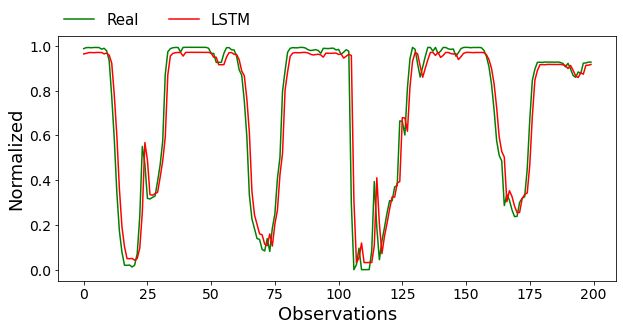

In [37]:
plt.figure(figsize=(10, 4.5))

plt.plot(y_test[1000:1200], label='Real', color='green')

plt.plot(y_pred_lstm_horizon1[1000:1200], label='LSTM', color='red')

plt.xlabel('Observations', fontsize=18)
plt.ylabel('Normalized', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=5, 
           borderaxespad=0, frameon=False, prop={"size":15})
plt.show()